<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_4th_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [ ]:
!wget --help

In [2]:
!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv -P /drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet -P /drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl -P /drive/MyDrive/MeLi-2021/row/
!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz -P /drive/MyDrive/MeLi-2021/row/

--2021-07-24 23:44:46--  https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.217.102.236
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.217.102.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5075979 (4.8M) [text/csv]
Saving to: ‘/drive/MyDrive/MeLi-2021/row/test_data.csv’

test_data.csv       100%[===================>]   4.84M  3.30MB/s    in 1.5s    

2021-07-24 23:44:49 (3.30 MB/s) - ‘/drive/MyDrive/MeLi-2021/row/test_data.csv’ saved [5075979/5075979]

--2021-07-24 23:44:49--  https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.217.89.132
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.217.89.132|:443... connected.
HTTP request sent, awaiting response... 

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz 
!wget -P spark_tgz/ http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz

--2021-07-24 23:46:25--  http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 95.216.26.30, 2a01:4f9:2a:1a61::2
Connecting to www-eu.apache.org (www-eu.apache.org)|95.216.26.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz [following]
--2021-07-24 23:46:25--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 135.181.209.10, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  10.3MB/s    in 24s     

2021-07-24 23:46:51 (9.27 MB/s) - ‘spark_tgz/spark-2

In [4]:
!tar -xf spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz -C spark_tgz/
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 212.4 MB 40 kB/s 
     |████████████████████████████████| 198 kB 50.0 MB/s 


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark_tgz/spark-2.4.8-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [7]:
import pandas as pd 
import numpy as np


In [7]:
df_spark = spark.read.format('parquet').load("/drive/MyDrive/MeLi-2021/row/train_data.parquet")

In [8]:
df_spark.count()

37660279

In [9]:
df_spark.createOrReplaceTempView('df')

In [10]:
spark.sql("""
SELECT df.*
  ,minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) diff_minutes_active
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) < 0 THEN 'Ruptura'END) Ruptura
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) > 0 THEN 'Estoque'END) Estoque
  
FROM df
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')

In [11]:
spark.sql("""
SELECT df_re.*
  ,CASE WHEN Ruptura is null and Estoque is null and minutes_active>0 and diff_minutes_active is null then 'Estoque'
        --WHEN Estoque is not null then 'Estoque'
        WHEN minutes_active = diff_minutes_active	and Estoque is not null then 'Estoque'
        --WHEN Ruptura is not null and Estoque is null then 'Ruptura'
        WHEN Ruptura is not null and Estoque is null and minutes_active=0  then 'Ruptura'
        END STATUS_RUPTURA
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [12]:
spark.sql("""
SELECT df_re.*
  ,COUNT(CASE WHEN STATUS_RUPTURA IS NOT NULL THEN 1 END) over (partition by sku order by date ) ciclo_ruptura
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [13]:
spark.sql("""
SELECT df_re.*
  ,SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) sum_sold_quantity 
  ,sum(case when sold_quantity >0 then current_price*sold_quantity end) over (partition by sku,ciclo_ruptura order by date desc)/SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) avg_current_price 
  ,SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc)/60/24 days_active_nround
  ,round(SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc) /60/24 + 0.5,0) days_active 
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [14]:
spark.sql("""
SELECT df_re.*  
  ,min(days_active_nround) over (partition by sku,ciclo_ruptura order by date desc)>0 FLG_ruptura 
FROM df_re
--where sku = 0
--order by sku, date
""").filter('FLG_ruptura=True').drop(*['sold_quantity','minutes_active','diff_minutes_active',	'Ruptura',	'Estoque',	'STATUS_RUPTURA',	'ciclo_ruptura']).createOrReplaceTempView('df_final')#.toPandas()

In [15]:
%%time
spark.sql("""
SELECT *
FROM df_final
""").write.mode('overwrite').format('parquet').save('data/tabelao/')

CPU times: user 980 ms, sys: 98.7 ms, total: 1.08 s
Wall time: 3min 31s


In [16]:
df = spark.read.format('parquet').load('data/tabelao/')

In [17]:
df.count()

28096162

In [18]:
spark.sql("""
SELECT sku
  , sum(sold_quantity) total_sold_quantity 
  , max(sold_quantity) max_sold_quantity 
  , min(case when sold_quantity>0 then sold_quantity end) min_sold_quantity 
  , avg(case when sold_quantity>0 then sold_quantity end) avg_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.5) median_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.25) qt1_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.75) qt3_sold_quantity 

  , sum(current_price*sold_quantity) total_fat 
  , max(current_price*sold_quantity) max_fat  
  , min(case when sold_quantity>0 then current_price*sold_quantity end) min_fat 
  , avg(case when sold_quantity>0 then current_price*sold_quantity end) avg_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5) median_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25) qt1_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75) qt3_fat

  , sum(case when sold_quantity>0 then current_price*sold_quantity end)/sum(sold_quantity) avg_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5)/sum(sold_quantity) median_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25)/sum(sold_quantity) qt1_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75)/sum(sold_quantity) qt3_price
FROM df
GROUP BY sku
""").repartition(1).write.mode('overwrite').format('parquet').save('data/agreg/')

In [19]:
g_df = spark.read.format('parquet').load('data/agreg/')
g_df.createOrReplaceTempView('g_df')

In [23]:
spark.read.format('json').load('items_static_metadata_full.jl').createOrReplaceTempView('items')

In [43]:
spark.sql("""
SELECT df_final.sku ,
  date ,
  current_price ,
  currency ,
  listing_type ,
  shipping_logistic_type ,
  shipping_payment ,
  sum_sold_quantity ,
  avg_current_price ,
  days_active_nround ,
  days_active ,
  FLG_ruptura ,

  total_sold_quantity ,
  max_sold_quantity ,
  min_sold_quantity ,
  avg_sold_quantity ,
  median_sold_quantity ,
  qt1_sold_quantity ,
  qt3_sold_quantity ,
  total_fat ,
  max_fat ,
  min_fat ,
  avg_fat ,
  median_fat ,
  qt1_fat ,
  qt3_fat ,
  avg_price ,
  median_price ,
  qt1_price ,
  qt3_price ,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 

FROM df_final
LEFT JOIN g_df 
  ON g_df.sku = df_final.sku
LEFT JOIN items 
  ON items.sku = df_final.sku
""").createOrReplaceTempView('df_final_join')

In [47]:
spark.read.option("header",True).format('csv').load('test_data.csv').createOrReplaceTempView('test_data')


In [48]:
spark.sql("""
SELECT test_data.sku ,
  target_stock ,
  total_sold_quantity ,
  max_sold_quantity ,
  min_sold_quantity ,
  avg_sold_quantity ,
  median_sold_quantity ,
  qt1_sold_quantity ,
  qt3_sold_quantity ,
  total_fat ,
  max_fat ,
  min_fat ,
  avg_fat ,
  median_fat ,
  qt1_fat ,
  qt3_fat ,
  avg_price ,
  median_price ,
  qt1_price ,
  qt3_price ,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 
FROM test_data
LEFT JOIN g_df 
  ON g_df.sku = test_data.sku
LEFT JOIN items 
  ON items.sku = test_data.sku
""").createOrReplaceTempView('test_data_join')

In [49]:
%%time
spark.sql("""
SELECT *
FROM df_final_join
""").repartition(1).write.mode('overwrite').format('parquet').save('data/df_final_join/')

CPU times: user 1.74 s, sys: 143 ms, total: 1.88 s
Wall time: 6min 33s


In [50]:
%%time
spark.sql("""
SELECT *
FROM test_data_join
""").repartition(1).write.mode('overwrite').format('parquet').save('data/test_data_join/')

CPU times: user 71.7 ms, sys: 8.48 ms, total: 80.2 ms
Wall time: 16 s


In [ ]:
df_train = spark.read.format('parquet').load('data/df_final_join/')
df_train = spark.read.format('parquet').load('data/df_final_join/')

In [5]:
from glob import glob 
loc_parquet = glob('data/tabela_final/*.parquet')
df = pd.read_parquet(loc_parquet[0])
#pd_df = df.toPandas()

In [6]:
df = df.loc[df.loc[:,'sum_sold_quantity']>0,:]

In [7]:
df.head()

,sku,date,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,days_active_nround,days_active,FLG_ruptura
0,264,2021-03-07,1151.69,MEX,premium,fulfillment,free_shipping,6,1151.690000,0.778449,1.0,True
1,264,2021-03-06,1151.69,MEX,premium,fulfillment,free_shipping,19,1151.690000,1.778449,2.0,True
2,264,2021-03-05,1151.69,MEX,premium,fulfillment,free_shipping,24,1151.690000,2.778449,3.0,True
3,264,2021-03-04,1087.73,MEX,premium,fulfillment,free_shipping,33,1134.246364,3.778449,4.0,True
4,264,2021-03-03,1095.98,MEX,premium,fulfillment,free_shipping,53,1119.806226,4.778449,5.0,True


In [8]:
df.shape  

(25326463, 12)

In [9]:
df.loc[df.sku==961,:]

,sku,date,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,days_active_nround,days_active,FLG_ruptura
163,961,2021-02-26,65.0,MEX,premium,fulfillment,paid_shipping,1,65.0,0.520315,1.0,True
164,961,2021-02-25,65.0,MEX,premium,fulfillment,paid_shipping,1,65.0,1.520315,2.0,True
165,961,2021-02-24,65.0,MEX,premium,fulfillment,paid_shipping,1,65.0,2.520315,3.0,True
166,961,2021-02-23,65.0,MEX,premium,fulfillment,paid_shipping,6,65.0,3.520315,4.0,True
167,961,2021-02-22,65.0,MEX,premium,fulfillment,paid_shipping,8,65.0,4.520315,5.0,True
168,961,2021-02-21,65.0,MEX,premium,fulfillment,paid_shipping,8,65.0,5.520315,6.0,True
169,961,2021-02-20,65.0,MEX,premium,fulfillment,paid_shipping,9,65.0,6.520315,7.0,True
170,961,2021-02-19,65.0,MEX,premium,fulfillment,paid_shipping,9,65.0,7.520315,8.0,True
171,961,2021-02-18,65.0,MEX,premium,fulfillment,paid_shipping,12,65.0,8.520315,9.0,True
172,961,2021-02-17,65.0,MEX,premium,fulfillment,paid_shipping,13,65.0,9.520315,10.0,True


In [10]:
df_test = pd.read_csv('test_data.csv')

In [27]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 18 kB/s 


In [11]:
from catboost import Pool, CatBoostClassifier

In [12]:
vars = ['sku',
 'sum_sold_quantity'
 ]
cat_vars =  ['sku'
 ]

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_data,test_data,train_label,test_label = train_test_split(df,df.days_active,train_size=.01,test_size=.01)

In [15]:
# initialize data
#train_data = g_df.loc[:,vars].sample(frac=.01,random_state=123)
#train_label = g_df.loc[:,'days_active'].apply(lambda x : x if x<30. else 30.).round().astype(int).sample(frac=.01,random_state=123)
#test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data.loc[:,vars], 
                  train_label, 
                  cat_features=cat_vars)
test_pool = Pool(test_data.loc[:,vars], 
                  test_label, 
                  cat_features=cat_vars)

# specify the training parameters 
model = CatBoostClassifier(n_estimators=100,learning_rate=0.1)
#train the model
model.fit(train_pool)
# make the prediction using the resulting model

0:	learn: 4.0359576	total: 31.9s	remaining: 52m 40s
1:	learn: 3.9991516	total: 1m 3s	remaining: 51m 34s
2:	learn: 3.9707702	total: 1m 34s	remaining: 51m 4s
3:	learn: 3.9481829	total: 2m 6s	remaining: 50m 24s
4:	learn: 3.9298043	total: 2m 37s	remaining: 49m 48s
5:	learn: 3.9144096	total: 3m 8s	remaining: 49m 17s
6:	learn: 3.9018846	total: 3m 40s	remaining: 48m 43s
7:	learn: 3.8911548	total: 4m 11s	remaining: 48m 8s
8:	learn: 3.8824909	total: 4m 42s	remaining: 47m 34s
9:	learn: 3.8750649	total: 5m 13s	remaining: 47m 2s
10:	learn: 3.8688938	total: 5m 40s	remaining: 45m 51s
11:	learn: 3.8635385	total: 6m 12s	remaining: 45m 31s
12:	learn: 3.8573374	total: 6m 45s	remaining: 45m 13s
13:	learn: 3.8523261	total: 7m 17s	remaining: 44m 44s
14:	learn: 3.8479791	total: 7m 48s	remaining: 44m 16s
15:	learn: 3.8446745	total: 8m 21s	remaining: 43m 51s
16:	learn: 3.8415831	total: 8m 53s	remaining: 43m 23s
17:	learn: 3.8386414	total: 9m 24s	remaining: 42m 51s
18:	learn: 3.8360826	total: 9m 57s	remaining:

KeyboardInterrupt: ignored

In [53]:
model.score(test_pool),model.score(train_pool)

(0.04253647365407774, 0.04928454103228252)

In [54]:
test_label.nunique()

60

In [58]:
def rps(predictions, observed):
  ncat = 60
  npred = len(predictions)
  rps = np.zeros(npred)

  for x in range(0, npred):
    obsvec = np.zeros(ncat)
    obsvec[int(observed.iloc[x]-1)] = 1
    cumulative = 0
    for i in range(1, ncat):
      cumulative += (sum(predictions.iloc[x, 0:i]) - sum(obsvec[0:i])) ** 2
      rps[x] = cumulative / (ncat-1)
  return rps

In [59]:
probs=model.predict_proba(test_data.loc[:,vars].iloc[:100,:])
probs

array([[5.32573102e-04, 3.70157514e-03, 6.77507104e-03, ...,
        1.28320124e-02, 1.86713287e-02, 1.22596771e-02],
       [1.55557152e-04, 7.34056350e-04, 3.21595448e-04, ...,
        1.00420683e-02, 2.14414204e-02, 9.00016870e-03],
       [7.98456827e-02, 8.02318518e-02, 7.08264279e-02, ...,
        3.06730538e-04, 2.74312853e-03, 5.73992975e-05],
       ...,
       [1.47708923e-03, 4.50209070e-03, 1.13467865e-02, ...,
        7.54654987e-03, 6.51116437e-03, 5.36881790e-03],
       [1.45306537e-03, 1.49297415e-03, 1.46622736e-03, ...,
        8.25726591e-03, 1.05186611e-02, 3.85783345e-03],
       [4.17545897e-02, 6.72582371e-02, 6.49721590e-02, ...,
        4.93326239e-04, 6.26258973e-04, 6.26482394e-04]])

In [60]:
sum(rps(pd.DataFrame(probs),test_label.iloc[:100]))

12.803582784208983

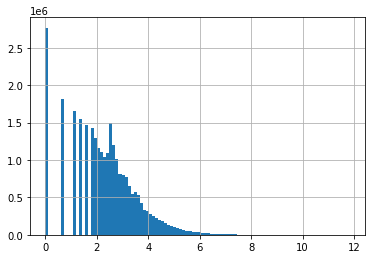

In [36]:
np.log1p(df.sum_sold_quantity).hist(bins=100)

In [38]:
df.loc[df.sum_sold_quantity==0,:]


,sku,date,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,days_active_nround,days_active,FLG_ruptura
189,961,2021-03-31,75.0,MEX,premium,fulfillment,paid_shipping,0,NaN,1.000000,2.0,True
190,961,2021-03-30,75.0,MEX,premium,fulfillment,paid_shipping,0,NaN,2.000000,3.0,True
191,961,2021-03-29,75.0,MEX,premium,fulfillment,paid_shipping,0,NaN,3.000000,4.0,True
192,961,2021-03-28,75.0,MEX,premium,fulfillment,paid_shipping,0,NaN,4.000000,5.0,True
193,961,2021-03-27,75.0,MEX,premium,fulfillment,paid_shipping,0,NaN,5.000000,6.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
28096102,660831,2021-03-14,113.5,REA,classic,drop_off,free_shipping,0,NaN,17.236343,18.0,True
28096103,660886,2021-03-31,52.0,REA,classic,fulfillment,paid_shipping,0,NaN,1.000000,2.0,True
28096104,660886,2021-03-30,52.0,REA,classic,fulfillment,paid_shipping,0,NaN,2.000000,3.0,True
28096105,660886,2021-03-29,52.0,REA,classic,fulfillment,paid_shipping,0,NaN,3.000000,4.0,True


In [ ]:
df

In [39]:
df.sum_sold_quantity.value_counts()

0        2769699
1        1820181
2        1654962
3        1548618
4        1468748
          ...   
6285           1
18628          1
6290           1
6294           1
16361          1
Name: sum_sold_quantity, Length: 8241, dtype: int64

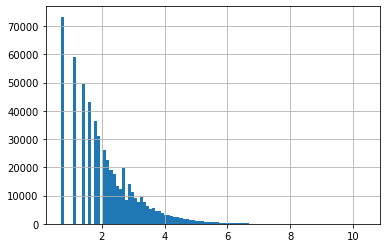

In [41]:
df_test.loc[:,'sum_sold_quantity'] = df_test.target_stock
np.log1p(df_test.sum_sold_quantity).hist(bins=100)

In [ ]:
df_test.sum_sold_quantity.describe(),df.sum_sold_quantity.describe()

In [ ]:
df_test.loc[:,'sum_sold_quantity'] = df_test.target_stock
test_data = df_test.loc[:,vars]
test_pool = Pool(test_data,
                 cat_features=cat_vars) 


In [ ]:
pd.DataFrame(model.predict(test_data)).describe()#.hist()

In [ ]:
pd.DataFrame(model.predict(test_data)).hist()

In [ ]:
pd.DataFrame(model.predict(test_data)).apply(lambda x : x[0] if x[0]<30 else 30,axis=1).hist()

In [ ]:
result = pd.DataFrame(model.predict_proba(test_data)).round(4)#.to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)

In [ ]:
result.loc[:,29] = result.loc[:,29:].sum(axis=1)

In [ ]:
result.loc[:,:29].to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)